In [1]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax.experimental.ode import odeint

import time

# RELOADING MODULES
import importlib
import neural_net_pyomo
import matplotlib.pyplot as plt

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

import non_parametric_collocation 
importlib.reload(non_parametric_collocation)
collocate_data = non_parametric_collocation.collocate_data

import data_generation 
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

In [2]:
from scipy.integrate import solve_ivp

## `Toy dataset check`

In [3]:
def create_delayed_embeddings(x, tau, m):
    # Total length of the time series
    n = x.shape[0]
    
    # Initialize an empty list to store the embedding vectors
    embeddings = []
    
    # Loop over the time series to create each embedding vector
    # Only go up to points where a full embedding can be created
    for i in range(n - (m - 1) * tau):
        # Create the embedding vector by slicing the array
        embedding = jnp.array([x[i + j * tau] for j in range(m)])
        embeddings.append(embedding)
    
    # Convert list of embeddings to a Jax array
    return jnp.vstack(embeddings)

In [5]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 400
noise_level = 0.2
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [6]:
u = np.atleast_2d(y_noisy).T
r, c = u.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 400; c : 1
r : 400; c : 1


In [7]:
importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [8]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  
    
    embeddings = []  
    
    for i in range(n - m * tau):  
        embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)

tau = 1
m = 2
embeddings = create_delayed_embeddings(y, tau, m)
print("Embedding shape:", embeddings.shape)

Embedding shape: (398, 2)


In [9]:
embeddings = np.array(embeddings)
embeddings.shape

(398, 2)

In [ ]:
embeddings - u[offset:]

In [73]:
offset = m*tau
layer_widths = [2, 10, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-8, "print_level": 5, 
          # "hessian_approximation": 'limited-memory', 
          # 'mu_strategy': 'adaptive', 
          "dual_inf_tol": 1e-5, 
          "constr_viol_tol": 1e-5, 
          "compl_inf_tol": 1e-5,
          "check_derivatives_for_naninf": 'yes'}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u[offset:], t[offset:], D[offset:, offset:],
                           layer_widths, max_iter = 2000, act_func = "tanh", 
                           y_init = u_estimated, penalty_lambda = 0.0001, 
                           penalty_lambda_input = 0.001,
                           extra_input = embeddings, 
                           w_init_method = 'xavier', params = params
                           ) # , extra_input = t

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: max_iter=2000
halt_on_ampl_error=yes
tol=1e-08
print_level=5
dual_inf_tol=1e-05
constr_viol_tol=1e-05
compl_inf_tol=1e-05
check_derivatives_for_naninf=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   175120
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    95821

Total number of variables............................:      440
                     variables with only lower bounds:        0
                variables with lower and upper 

In [74]:
t_new = t[offset:]

def system_dynamics(t, y, embeddings, t_new):
    # -1 to account for the zero indexing
    current_index = np.searchsorted(t_new, t, side='right') - 1
    
    input = np.array([y[0]])
    
    # for each embedding:
    for i in range(m):
        input = np.append(input, embeddings[current_index][i])
        
    # input = np.array([y[0]])
    du_dt = ode_model.predict(input) 
    return du_dt

initial_conditions = np.array(u[offset])
t_span = (t_new[0], t_new[-1])
sol = solve_ivp(system_dynamics, t_span, initial_conditions, t_eval=t_new, args=(embeddings,t_new))

y_pred_train = sol.y
t_points = sol.t

ode_solution = np.squeeze(y_pred_train.T)

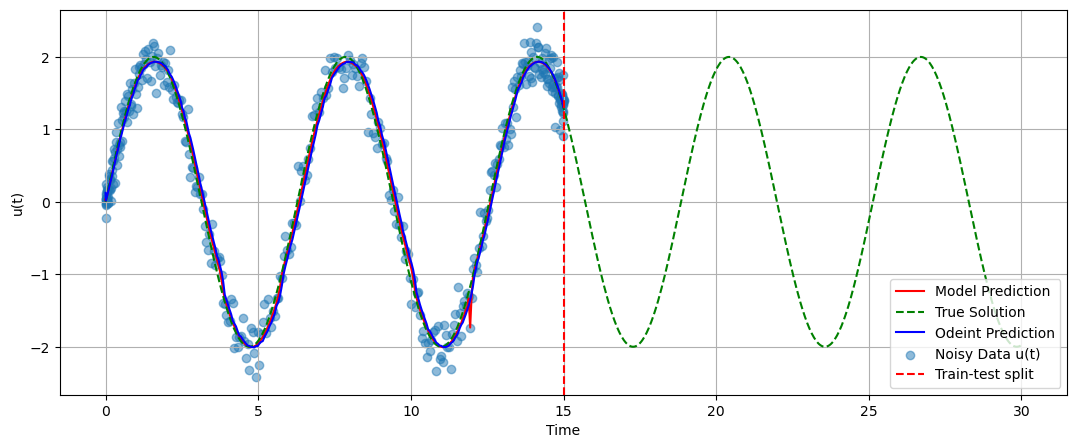

In [75]:
i = 400
y_model = ode_model.extract_solution().T

plt.figure(figsize=(13, 5))
plt.plot(t[offset:], np.squeeze(y_model), 'r', label='Model Prediction')
plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.plot(t_new, ode_solution, 'b', label='Odeint Prediction')

#plt.plot(t_test_new, predictions_test.T)
plt.scatter(t[:i], y_noisy.T[:i], label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

#### []---[previous_state]---[current_state]---[prediction]---[]

### `manual Euler approach`

### `odeint`

In [77]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 2.325e-04  9.299e-04 ...  1.500e+01  1.500e+01]
        y: [[ 1.247e-01  1.031e-01 ...  1.307e+00  1.307e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 18044
     njev: 0
      nlu: 0

In [131]:
last_train_state = y_pred_train[:, -1]
threshold = int(t_test.shape[0]/2)
t_test_new = t_test[threshold:]
y_test_new = y_test[threshold:]
y_train_new = y_test[:threshold]

In [132]:
current_state

array([1.27182402])

In [145]:
def system_dynamics_test(t, y, embeddings, t_new):
    # -1 to account for the zero indexing
    input = np.array([y[0]])
    # for each embedding:
    for i in range(len(embeddings)):
        input = np.append(input, embeddings[i])
    du_dt = ode_model.predict(input) 
    return du_dt

current_state = np.array(y_test_new[0])
prev_state = np.array(y_train_new[-1])

predictions_test = [current_state]

for i in range(1, len(t_test_new)):
    t_span = (t_test_new[i - 1], t_test_new[i])
    sol = solve_ivp(system_dynamics_test, t_span, current_state, t_eval=[t_test_new[i]], args=(prev_state, t_new))
    
    # prev_state = np.array(y_test_new[i - 1])
    prev_state = current_state
    current_state = sol.y[:, -1]
    
    predictions_test.append(current_state)

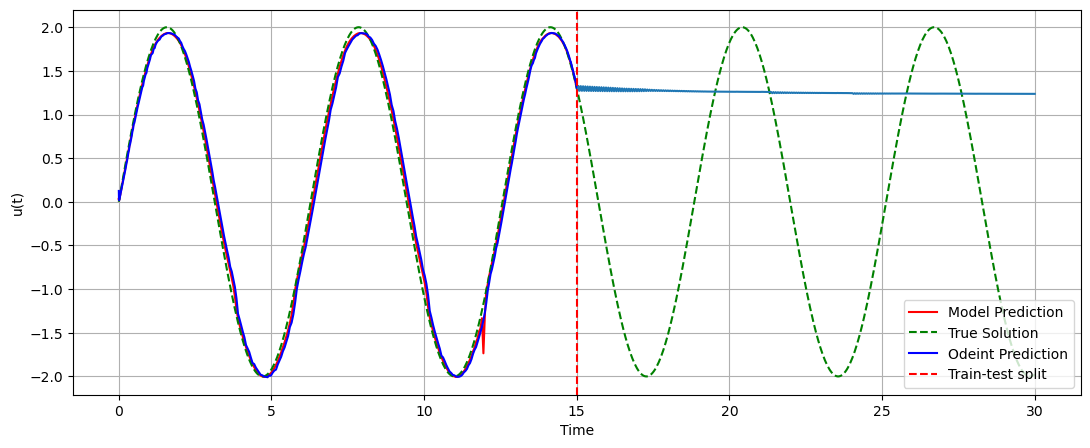

In [146]:
i = 400
y_model = ode_model.extract_solution().T

plt.figure(figsize=(13, 5))
plt.plot(t[offset:], np.squeeze(y_model), 'r', label='Model Prediction')
plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.plot(t_new, ode_solution, 'b', label='Odeint Prediction')
plt.plot(t_test_new[:i], predictions_test[:i])
#plt.scatter(t[:n], y_noisy.T[:n], label='Noisy Data u(t)', alpha = 0.5)

"""p = 546
plt.plot(t_test[p], y_test[p-1], "o", color = "orange")
input = jnp.array([y_test[p][0], y_test[p-1][0]])
du_dt = ode_model.predict(input)
print(du_dt)"""

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

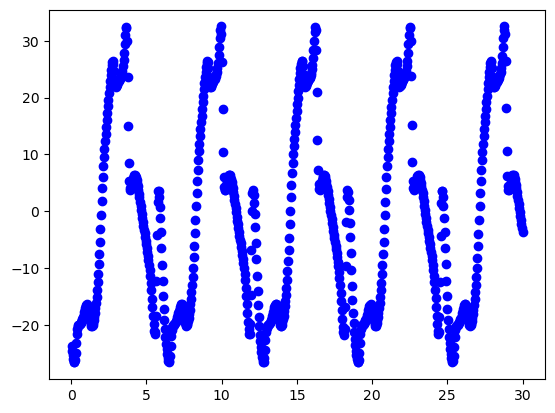

In [148]:
for p in range(1,800):
    # plt.plot(t_test[p], y_test[p-1], "o", color = "orange")
    input = jnp.array([y_test[p][0], y_test[p-1][0]])
    du_dt = ode_model.predict(input)
    plt.plot(t_test[p], du_dt, "o", color = "blue")
    # print(du_dt)

### If `t` is passed as a parameter

In [160]:
n = 400
layer_widths = [2, 20, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-8, "print_level": 5, 
          # "hessian_approximation": 'limited-memory', 
          # 'mu_strategy': 'adaptive', 
          "dual_inf_tol": 1e-5, 
          "constr_viol_tol": 1e-6, "compl_inf_tol": 1e-5,
          "check_derivatives_for_naninf": 'yes'
          }

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u[:n], t[:n], D[:n, :n], layer_widths, max_iter = 1000, 
                           act_func = "tanh", y_init = u_estimated, penalty_lambda = 0.01, time_invariant=False,
                            penalty_lambda_input = 0.0001, 
                            w_init_method = 'xavier', params = params
                           ) # , extra_input = t

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: max_iter=1000
halt_on_ampl_error=yes
tol=1e-08
print_level=5
hessian_approximation=limited-memory
mu_strategy=adaptive
dual_inf_tol=1e-05
constr_viol_tol=1e-06
compl_inf_tol=1e-05
check_derivatives_for_naninf=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   191919
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      481
                     variables with only lower bounds

Train MAE: 0.3358160203144828
Test MAE: 5.339211578950775


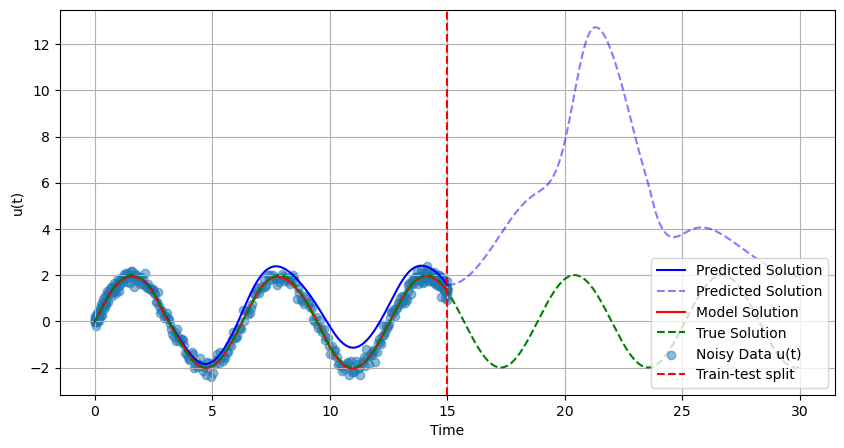

In [161]:
y_model = ode_model.extract_solution().T

def system_dynamics(y, t):
    input = jnp.array([y[0], t])
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])

initial_conditions = jnp.array([0.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t)
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test[N:]))
print(f"Test MAE: {mae_test}")

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test[N:], y_pred_test, 'b--', label='Predicted Solution', alpha = 0.5)

plt.plot(t[:n], np.squeeze(y_model), 'r', label='Model Solution')
plt.plot(t_test, y_test, 'g--', label='True Solution')

plt.scatter(t[:n], y_noisy.T[:n], label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()